### Introduction 

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

### Exploration

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Read in the data file
bike_rentals = pd.read_csv("bike_rental_hour.csv")

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns obtained from [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset):

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered


In [30]:
# Remove casual and registered riders as these columns sum to cnt
# Also remove instant as this is just an index value

bike_rentals = bike_rentals.drop(columns=["casual","registered","instant"])

In [31]:
# Determine if the dteday column needs to be converted to datetime
print(bike_rentals["dteday"].dtype)

# Convert to datetime
if bike_rentals["dteday"].dtype == "object":
    bike_rentals["dteday"] = pd.to_datetime(bike_rentals["dteday"])

bike_rentals["dteday"].dtype

object


dtype('<M8[ns]')

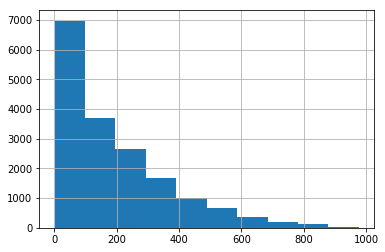

In [32]:
# Plot cnt to visulize the target column

bike_rentals["cnt"].hist()

Thus we can see that on the vast majority of hours less than 250 bikes are rented and that frequency decreases steadily in line with number of bikes per hour.

In [33]:
# Determine the correlation of each column with the "cnt" column

bike_rentals.corr()["cnt"].sort_values(ascending=False)

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

### Additional columns

In [34]:
# Before creating new columns and deleting old ones, save the original df for use later

original_df = bike_rentals.copy()

Before deleting the columns with low correlation coefficients with "cnt". Let's assemble some new, potentially useful columns.

<BarContainer object of 24 artists>

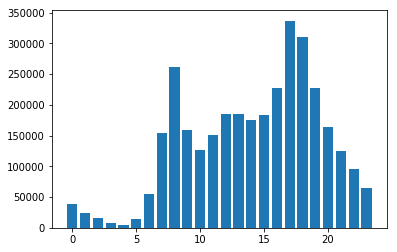

In [35]:
# Split apart each day into different sections
# Plot cnt per hour to determine where to split the time periods
x = bike_rentals["hr"].unique()
height = [bike_rentals.loc[bike_rentals["hr"] == hr, "cnt"].sum() for hr in x]

plt.bar(x=x, height=height)

In [36]:
# Add a time_label column to show whether it is morning, mid_day, afternoon, evening or night

def create_time_label(hour):
    if hour >= 6 and hour < 11:
        return "morning"
    elif hour >= 11 and hour < 15:
        return "mid_day"
    elif hour >= 15 and hour < 18:
        return "afternoon"
    elif hour >= 18 and hour < 22:
        return "evening"
    else:
        return "night"
    
# Add the column to the dataframe and then use the df.get_dummies function to create seperate columns 
bike_rentals["time_label"] = bike_rentals["hr"].apply(create_time_label)

bike_rentals = pd.get_dummies(bike_rentals, prefix="time_label", columns=["time_label"])
    
bike_rentals.head()


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label_afternoon,time_label_evening,time_label_mid_day,time_label_morning,time_label_night
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,0,0,0,0,1
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,0,0,0,0,1
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,0,0,0,0,1
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,0,0,0,0,1
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,0,0,0,0,1


In [37]:
# Also create dummy columns for each day of the week as it is possible that certain days have 
# different characteristics

bike_rentals = pd.get_dummies(bike_rentals, prefix="day", columns=["weekday"])

bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,temp,atemp,...,time_label_mid_day,time_label_morning,time_label_night,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,2011-01-01,1,0,1,0,0,0,1,0.24,0.2879,...,0,0,1,0,0,0,0,0,0,1
1,2011-01-01,1,0,1,1,0,0,1,0.22,0.2727,...,0,0,1,0,0,0,0,0,0,1
2,2011-01-01,1,0,1,2,0,0,1,0.22,0.2727,...,0,0,1,0,0,0,0,0,0,1
3,2011-01-01,1,0,1,3,0,0,1,0.24,0.2879,...,0,0,1,0,0,0,0,0,0,1
4,2011-01-01,1,0,1,4,0,0,1,0.24,0.2879,...,0,0,1,0,0,0,0,0,0,1


In [38]:
# Also create dummy columns for the seasons

bike_rentals = pd.get_dummies(bike_rentals, prefix="season", columns=["season"])

bike_rentals.head()

,dteday,yr,mnth,hr,holiday,workingday,weathersit,temp,atemp,hum,...,day_1,day_2,day_3,day_4,day_5,day_6,season_1,season_2,season_3,season_4
0,2011-01-01,0,1,0,0,0,1,0.24,0.2879,0.81,...,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,0,1,1,0,0,1,0.22,0.2727,0.80,...,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,0,1,2,0,0,1,0.22,0.2727,0.80,...,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,0,1,3,0,0,1,0.24,0.2879,0.75,...,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,0,1,4,0,0,1,0.24,0.2879,0.75,...,0,0,0,0,0,1,1,0,0,0


In [39]:
# Let's determine if we change the windy column to a binary column showing one only if it is very windy
# if this increases correlation with cnt

# First look at the value_counts for the windspeed column
bike_rentals["windspeed"].value_counts()

0.0000    2180
0.1343    1738
0.1642    1695
0.1940    1657
0.1045    1617
0.2239    1513
0.0896    1425
0.2537    1295
0.2836    1048
0.2985     808
0.3284     602
0.3582     460
0.3881     381
0.4179     296
0.4478     176
0.4627     146
0.4925     112
0.5224      84
0.5821      44
0.5522      39
0.6119      23
0.6418      14
0.6567      11
0.6866       5
0.8507       2
0.8060       2
0.7463       2
0.7164       2
0.7761       1
0.8358       1
Name: windspeed, dtype: int64

In [40]:
# Let's only say it's very windy if there's a value of over 0.3

def determine_very_windy(windspeed):
    if windspeed > 0.3:
        return 1
    else:
        return 0
    
windy_test = pd.DataFrame()
    
windy_test["very_windy"] = bike_rentals["windspeed"].apply(determine_very_windy)
windy_test["cnt"] = bike_rentals["cnt"].copy()

windy_test.corr()

,very_windy,cnt
very_windy,1.000000,0.032652
cnt,0.032652,1.000000


In [41]:
# Thus the windspeed does not seem to be a factor and should be removed
bike_rentals = bike_rentals.drop(columns=["windspeed"])

### Models

Error metric:

We will use Mean Square Error as the error metric as this is suitable for continuous data and penalises large errors more than small errors.

Let's also have a look at Mean Absolute Error as this is easier to interperet

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Train and test sets:

In [43]:
train = bike_rentals.sample(frac = 0.8, random_state = 1)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

#### Linear Regression

In [44]:
# Determine Suitable columns
all_columns = ['dteday', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'cnt', 'time_label_afternoon',
       'time_label_evening', 'time_label_mid_day', 'time_label_morning',
       'time_label_night', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'season_1', 'season_2', 'season_3', 'season_4']

features = ['holiday', 'weathersit',
       'temp', 'atemp', 'hum', 'time_label_afternoon',
       'time_label_evening', 'time_label_mid_day', 'time_label_morning',
       'time_label_night', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'season_1', 'season_2', 'season_3', 'season_4']

In [45]:
# Build the model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[features], train["cnt"])

# Evaluate the model
train_predictions = lr.predict(train[features])
predictions = lr.predict(test[features])

mse_train = mean_squared_error(train["cnt"], train_predictions)
mae_train = mean_absolute_error(train["cnt"], train_predictions)

mse = mean_squared_error(test["cnt"], predictions)
mae = mean_absolute_error(test["cnt"], predictions)

print(f"MSE Test: {mse}\nMAE Test: {mae}\nMSE Train: {mse_train}\nMAE Train: {mae_train}")

MSE Test: 16317.221806674339
MAE Test: 93.88578826237054
MSE Train: 16995.885060778248
MAE Train: 95.59634611234985


The model seems to be neither highly over or underfitted as the error metrics are similar for the train and test data

#### Decision Tree

In [52]:
bike_rentals = original_df

train = bike_rentals.sample(frac = 0.8, random_state = 1)

test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

features = ['season','mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

In [53]:
# Build the model
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_split = 80, max_depth= 10)
dtr.fit(train[features], train["cnt"])

# Evaluate the model
train_predictions = dtr.predict(train[features])
predictions = dtr.predict(test[features])

mse_train = mean_squared_error(train["cnt"], train_predictions)
mae_train = mean_absolute_error(train["cnt"], train_predictions)

mse = mean_squared_error(test["cnt"], predictions)
mae = mean_absolute_error(test["cnt"], predictions)

print(f"MSE Test: {mse}\nMAE Test: {mae}\nMSE Train: {mse_train}\nMAE Train: {mae_train}")

MSE Test: 6402.39324138971
MAE Test: 52.93274516456189
MSE Train: 5515.95884536264
MAE Train: 49.582477618413456


This error is lower than for the linear regression model but there is a higher degree of overfitting. Measures have been taken to reduce overfitting such as the use of the min_samples_split and max_depth parameters for the model.

#### Random Forrest

In [54]:
# Build the model
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 10, min_samples_split = 80, max_depth= 10, random_state = 1)
rfr.fit(train[features], train["cnt"])

# Evaluate the model
train_predictions = rfr.predict(train[features])
predictions = rfr.predict(test[features])

mse_train = mean_squared_error(train["cnt"], train_predictions)
mae_train = mean_absolute_error(train["cnt"], train_predictions)

mse = mean_squared_error(test["cnt"], predictions)
mae = mean_absolute_error(test["cnt"], predictions)

print(f"MSE Test: {mse}\nMAE Test: {mae}\nMSE Train: {mse_train}\nMAE Train: {mae_train}")

MSE Test: 5772.542573503909
MAE Test: 50.8857924132112
MSE Train: 5272.432413909471
MAE Train: 48.975942682415635


The Random Forest Regressor has performed the best as seen by it having the lowest error metrics of the three models while also having the lowest level of evidenced overfitting.